In [28]:
from ProFAST import ProFAST
import numpy as np
import matplotlib.pyplot as plt

In [29]:
pf = ProFAST()

In [30]:
print(pf.__doc__)


    A class to represent a ProFAST scenario

    Attributes
    ----------
    vals : dict
        Dictionary of all variables
    feedstocks : dict
        Dictionary for any feedstocks
    coproducts : dict
        Dictionary for any coproducts
    fixed_costs : dict
        Dictionary for any fixed costs
    capital_items : dict
        Dictionary for any capital items
    incentives : dict
        Dictionary for any incentives

    Methods
    -------
    load_json(file):
        Import a scenario from a JSON formatted input file
    set_params(name,value):
        Set parameter <name> to <value>
    load_MACRE_table():
        Load in MACRS depreciation table from csv
    add_capital_item(name,cost,depr_type,depr_period,refurb):
        Add a capital item
    add_feedstock(name,usage,unit,cost,escalation):
        Add a feedstock (expense)
    add_coproduct(name,usage,unit,cost,escalation):
        Add a coproduct (revenue)
    add_fixed_cost(name,usage,unit,cost,escalation):
   

Set parameter values for the financial model 

In [31]:
# Define general inflation rate
gen_inflation = 0.019

#   Sales specification
pf.set_params('commodity',{"name":'Hydrogen',"unit":"kg","initial price":4,"escalation":gen_inflation}) # Define the primary commodity
pf.set_params('analysis start year',2025)
pf.set_params('operating life',30) # Years of production
pf.set_params('installation months',20) # Months of installation (no production)
pf.set_params('demand rampup',2) # Years of ramp up (linear)
pf.set_params('long term utilization',0.9) # The utilization or capacity factor of the plant, relative to the nameplate capacity

# Installation information:
pf.set_params('capacity',50000) #units/day # Nameplate capacity
pf.set_params('installation cost',{"value":0,"depr type":"Straight line","depr period":5,"depreciable":False}) # Can be separated from capital items
pf.set_params('non depr assets',10000) # Such as land
pf.set_params('end of proj sale non depr assets',10000*(1+gen_inflation)**30) # Sale of land at project end
pf.set_params('maintenance',{"value":5000,"escalation":gen_inflation}) # Annual maintenance cost

#   Incentives specification
pf.set_params('one time cap inct',{"value":250000,"depr type":"MACRS","depr period":5,"depreciable":False}) # Such as a capital grant, cost share, or investment tax credit 
pf.set_params('annual operating incentive',{"value":1000,"decay":0,"sunset years":6,"taxable":True}) # Annual incentive (treated as income)
pf.set_params('incidental revenue',{"value":500,"escalation":gen_inflation}) # Such as coffee sales

#   Take or pay specification
pf.set_params('TOPC',{"unit price":1,"decay":0.01,"support utilization":0.6,"sunset years":3}) # Underutilization support

#   Other operating expenses
pf.set_params('credit card fees',0) # Fraction of sales revenue
pf.set_params('sales tax',0.023) # Fraction of sales revenue
# pf.set_params('road tax',{"value":0,"escalation":0}) # Cost per unit of commodity ($/kg)
pf.set_params('labor',{"value":20*40*52,"rate":20,"escalation":gen_inflation}) # 20 workers at 40hrs a week for 20$/hr
pf.set_params('license and permit',{'value':2000,'escalation':gen_inflation}) # $/yr for licensing and permitting 
pf.set_params('rent',{'value':50000,'escalation':gen_inflation}) # $/yr, for example for equipment
pf.set_params('property tax and insurance',0.009) # Fraction of plant property and equipment
pf.set_params('admin expense',0.005) # Fraction of sales revenue

#   Financing information
pf.set_params('total income tax rate',0.2574) # Combined tax rate
pf.set_params('capital gains tax rate',0.15) # Only for any gains made on non depreciable assets
pf.set_params('sell undepreciated cap',True)
pf.set_params('tax losses monetized',True) # Offset coupled business tax liabilities
pf.set_params('tax loss carry forward years',0) # If tax losses are carried forward
pf.set_params('general inflation rate',gen_inflation) 
pf.set_params('leverage after tax nominal discount rate',0.08) # Discount rate, and expected financial performance
pf.set_params('debt equity ratio of initial financing',1.5) # D2E ratio at start
pf.set_params('debt type','Revolving debt') # Bond/Revolving debt or one time loan
pf.set_params('loan period if used',0) # Only for one time loan
pf.set_params('debt interest rate',0.037) # Interest rate for loan
pf.set_params('cash onhand',1) # Number of month of monthly expenses in liquidity

Set the feedstocks

In [32]:
pf.add_feedstock(name='Water',usage=3.78,unit='gal',cost=0.005,escalation=gen_inflation) #3.78gal/kg H2
pf.add_feedstock(name='Electricity (industrial)',usage=55.5,unit='kWh',cost=0.15,escalation=gen_inflation)

You can also use dictionaries and list to set the usages and costs

In [33]:
years = list(map(str,range(2025-1,2025+30+2)))
elec_usage = np.linspace(55.5,65,len(years))
elec_usage_dict = dict(zip(years,elec_usage))
pf.add_feedstock(name='Electricity (industrial) dict',usage=elec_usage_dict,unit='kWh',cost=0.15,escalation=gen_inflation)
pf.remove_feedstock(name='Electricity (industrial) dict')

You can also use AEO feedstocks (Name and Cost must be valid values from AEO list)

In [34]:
pf.edit_feedstock(name='Electricity (industrial)',value={'cost':'Mountain'})
# AEO feedstocks can be modified for sensitivity analysis
pf.edit_feedstock(name='Electricity (industrial)',value={'usage':55.5,'cost':'1.1X Mountain'})

Set co-products

In [35]:
pf.add_coproduct(name='Oxygen',usage=7,unit='mol',cost=0.01,escalation=gen_inflation) 
pf.edit_coproduct(name='Oxygen',value={'usage':7})

Set the capital items. These have a depreciation and a refurbishment schedule

In [36]:
dol_per_kw = 500
kW = 50000/24*55.5
pf.add_capital_item(name='PEM Stack',cost=kW*dol_per_kw,depr_type='MACRS',depr_period=7,refurb=[0,0,0,0,0,0,0.15]*4) # Refurb 15% every 7 years
pf.add_capital_item(name='BOP',cost=1000000,depr_type='MACRS',depr_period=7,refurb=[0])

Set the fixed costs. which is a annual cost



In [37]:
pf.add_fixed_cost(name='Fixed costs',usage=1,unit='$',cost=3000000,escalation=gen_inflation)

Set the incentives, which is a per unit commodity based incentive

In [38]:
pf.add_incentive(name='PTC',value=3,decay=0,sunset_years=10,tax_credit=True)

This solves for the break even price - access it with sol["price"]

In [39]:
sol = pf.solve_price()

unit = pf.vals['commodity']['unit']
name = pf.vals['commodity']['name']
print('\n')
print(f'Levelized cost of {name} price: ${round(sol["lco"],2)}/{unit}')
print('\n')



Levelized cost of Hydrogen price: $1.48/kg




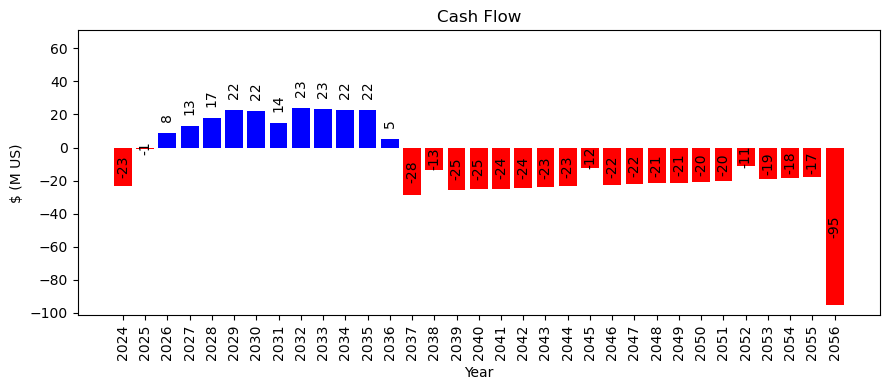

In [40]:
pf.plot_cashflow()

Plot the cost breakdowns

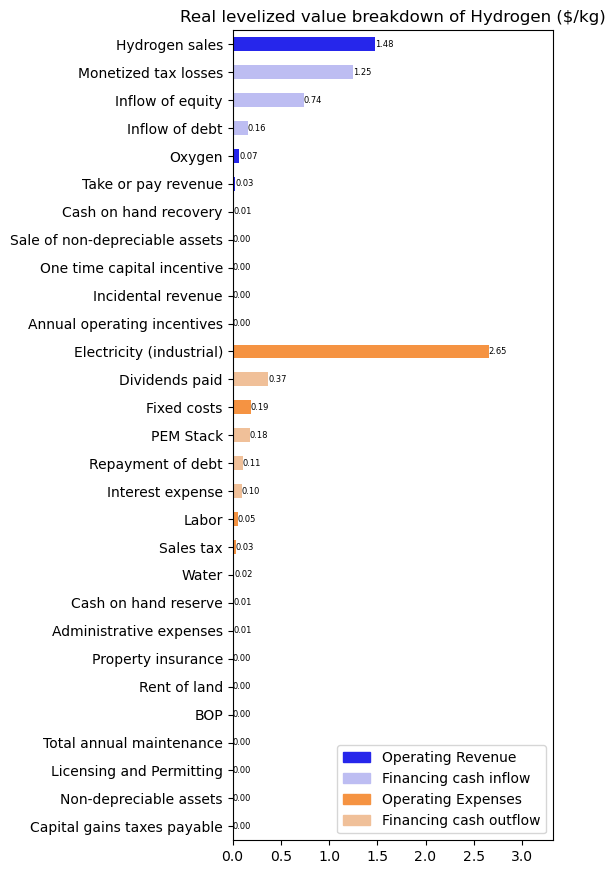

,Type,Name,Amount,NPV
4,Financing cash outflow,Capital gains taxes payable,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000001
5,Operating Expenses,Non-depreciable assets,"[-10000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.000021
6,Operating Expenses,Licensing and Permitting,"[0.0, 0.0, 679.3333333333331, 2076.72199999999...",0.000126
7,Operating Expenses,Total annual maintenance,"[0.0, 0.0, 1698.3333333333326, 5191.8049999999...",0.000315
8,Financing cash outflow,BOP,"[1000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.002139
9,Operating Expenses,Rent of land,"[0.0, 0.0, 16983.33333333333, 51918.0499999999...",0.003149
10,Operating Expenses,Property insurance,"[0.0, 0.0, 157683.54374999998, 338788.01249999...",0.003624
11,Operating Expenses,Administrative expenses,"[0.0, 0.0, 14382.321569752188, 58622.342718309...",0.007734
12,Operating Expenses,Cash on hand reserve,"[0.0, 80467.486225, 168677.20925887537, 0.0, 5...",0.008927
13,Operating Expenses,Water,"[0.0, 0.0, 35147.85749999999, 143262.66717, 25...",0.018900


In [41]:
pf.plot_costs()

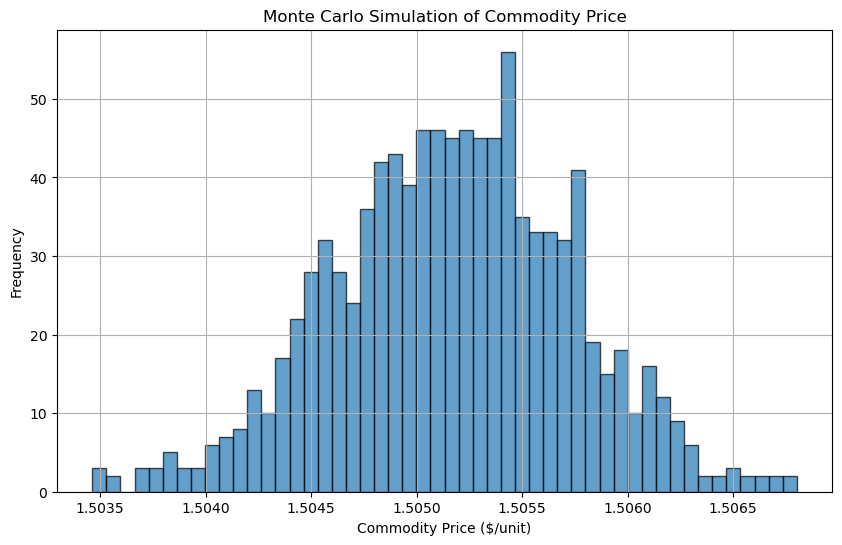

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ProFAST class is already implemented and available
# Let's say we have an instance of ProFAST initialized as `pf`

def monte_carlo_simulation(profast_instance, n_simulations=1000):
    """
    Perform Monte Carlo simulation to analyze the effect of varying parameters on commodity price.
    
    Parameters:
    -----------
    profast_instance: ProFAST
        An initialized instance of the ProFAST class
    n_simulations: int
        Number of Monte Carlo iterations
    
    Returns:
    --------
    prices: list
        List of commodity prices that result in NPV = 0 for each simulation
    """
    # Lists to store results
    prices = []
    inflation_rate_values = []
    capital_exp_values = []
    project_lifetime_values = []
    
    # Define probability distributions for key parameters
    # Example: Normal distribution for inflation rate, feedstock cost, capital expenditure
    inflation_rate_dist = np.random.normal(loc=0.02, scale=0.005, size=n_simulations)  # Mean 2%, SD 0.5%
    capital_exp_dist = np.random.normal(loc=1e6, scale=2e5, size=n_simulations)  # Mean $1M, SD $200k
    
    # Weibull distribution parameters for the project's lifetime
    shape_param = 1.5  # Shape parameter of Weibull (higher means more reliable project)
    scale_param = 30    # Scale parameter of Weibull (mean lifetime of 20 years)
    
    # Sample the project lifetime using a Weibull distribution
    project_lifetime_dist = np.random.weibull(shape_param, n_simulations) * scale_param
    
    # Loop over the number of simulations
    for i in range(n_simulations):
        # Modify ProFAST instance parameters with sampled values from distributions
        profast_instance.set_params('general inflation rate', inflation_rate_dist[i])

        
        # Modify capital expenditure for a specific capital item called 'CapitalItem_A'
        profast_instance.edit_capital_item('BOP', {'cost': capital_exp_dist[i]})
        
        # Run the solver to find the commodity price for NPV = 0
        result = profast_instance.solve_price(guess_value=2)  # Initial guess at price $2/unit
        
        # Append the resulting price and input values to the lists
        prices.append(result['price'])
        inflation_rate_values.append(inflation_rate_dist[i])
        capital_exp_values.append(capital_exp_dist[i])
        project_lifetime_values.append(project_lifetime_dist[i])
    
    # Create a DataFrame with all input values and the resulting prices
    sensitivity_df = pd.DataFrame({
        'Inflation Rate': inflation_rate_values,
        'Capital Expenditure': capital_exp_values,
        'Project Lifetime': project_lifetime_values,
        'Commodity Price': prices
    })
    
    return prices, sensitivity_df

def plot_simulation_results(prices):
    """
    Plot the results of the Monte Carlo simulation.
    
    Parameters:
    -----------
    prices: list
        List of commodity prices from the Monte Carlo simulation.
    """
    # Plot histogram of the prices
    plt.figure(figsize=(10, 6))
    plt.hist(prices, bins=50, edgecolor='k', alpha=0.7)
    plt.title("Monte Carlo Simulation of Commodity Price")
    plt.xlabel("Commodity Price ($/unit)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


# Run the Monte Carlo simulation
prices,sensitivity = monte_carlo_simulation(pf, n_simulations=1000)

# Plot the results of the Monte Carlo simulation
plot_simulation_results(prices)


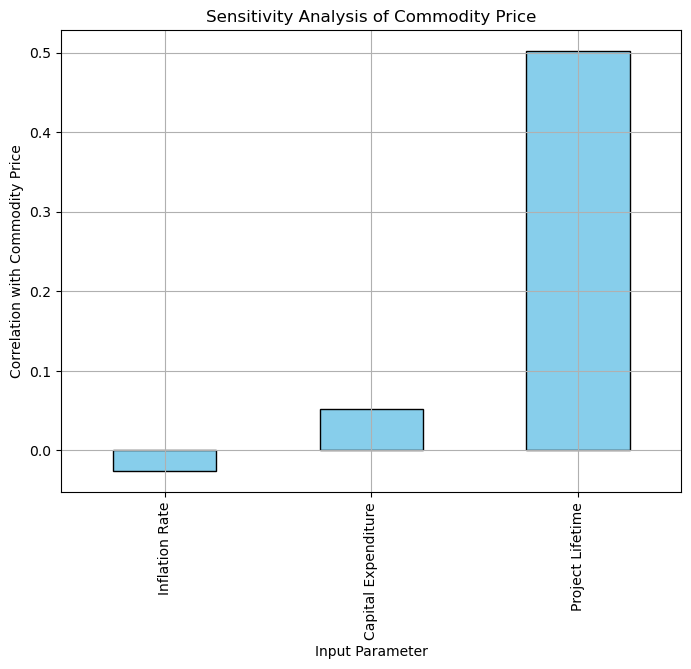

In [64]:
def sensitivity_analysis(sensitivity_df):
    """
    Perform sensitivity analysis by calculating correlations between the input parameters and the resulting commodity price.
    
    Parameters:
    -----------
    sensitivity_df: pd.DataFrame
        DataFrame containing the input parameters and resulting commodity prices
    
    Returns:
    --------
    correlations: pd.Series
        Correlation values for each input parameter with respect to the commodity price
    """
    # Calculate the correlation between each parameter and the commodity price
    correlations = sensitivity_df.corr()['Commodity Price'].drop('Commodity Price')
    
    # Plot the sensitivity analysis (bar chart of correlation values)
    plt.figure(figsize=(8, 6))
    correlations.plot(kind='bar', color='skyblue', edgecolor='k')
    plt.title("Sensitivity Analysis of Commodity Price")
    plt.xlabel("Input Parameter")
    plt.ylabel("Correlation with Commodity Price")
    plt.grid(True)
    plt.show()
    
    return correlations

# Perform and plot sensitivity analysis
correlations = sensitivity_analysis(sensitivity_df)

In [66]:
def tornado_chart(profast_instance):
    """
    Generate a tornado chart for sensitivity analysis.
    
    Parameters:
    -----------
    profast_instance: ProFAST
        The initialized ProFAST model instance
    
    Returns:
    --------
    None
    """
    # Define the parameters and their base values for sensitivity analysis
    base_params = {
        'Inflation Rate': profast_instance.vals['general inflation rate'],
        'Feedstock Cost': profast_instance.feedstocks['Feedstock_A'].cost,
        'Capital Expenditure': profast_instance.capital_items['CapitalItem_A'].cost,
        'Project Lifetime': profast_instance.vals['operating life']
    }
    
    # Define the percentage change for sensitivity analysis (e.g., +/- 10%)
    change_percent = 10
    
    # Lists to store the results of sensitivity analysis
    impacts = {}
    
    # Run sensitivity analysis for each parameter
    for param_name, base_value in base_params.items():
        # Calculate price when the parameter is increased by 10%
        price_up = run_sensitivity_analysis(profast_instance, param_name, base_value, change_percent)
        
        # Calculate price when the parameter is decreased by 10%
        price_down = run_sensitivity_analysis(profast_instance, param_name, base_value, -change_percent)
        
        # Calculate the impact (difference from base price)
        base_price = profast_instance.solve_price(guess_value=2)['price']
        impacts[param_name] = (price_down - base_price, price_up - base_price)
    
    # Prepare data for the tornado chart
    labels = list(impacts.keys())
    lows = [impacts[param][0] for param in labels]
    highs = [impacts[param][1] for param in labels]
    
    # Plot the tornado chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(labels, highs, left=base_price, color='lightgreen', label='+10% Change')
    ax.barh(labels, lows, left=base_price, color='salmon', label='-10% Change')
    
    plt.axvline(x=base_price, color='k', linestyle='--', label='Base Price')
    plt.xlabel('Commodity Price ($/unit)')
    plt.title('Tornado Chart: Sensitivity of Commodity Price to Input Parameters')
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming ProFAST instance (pf) is already initialized with default parameters
# pf = ProFAST()  # Initialize your ProFAST class here

# Generate and plot the tornado chart for sensitivity analysis
tornado_chart(sensitivity)
    


KeyError: 'Feedstock_A'